# Import the MIMIC data

In [1]:
import gzip
import pandas as pd
import glob
import numpy as np
import nltk

dataset_dictionary = {}

for file_path in glob.glob('.\\Data\\MIMIC Files\*'):
    file_name = file_path.split('\\')[3].split('.')[0]
    with gzip.open(file_path, mode='r') as file:
        dataset_dictionary[file_name] = pd.read_csv(file)

C:\Users\cells\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\cells\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
dataset_dictionary['NOTEEVENTS'].dtypes

ROW_ID           int64
SUBJECT_ID       int64
HADM_ID        float64
CHARTDATE       object
CHARTTIME       object
STORETIME       object
CATEGORY        object
DESCRIPTION     object
CGID           float64
ISERROR        float64
TEXT            object
dtype: object

In [3]:
dataset_dictionary['NOTEEVENTS']['CHARTDATE'] = pd.to_datetime(dataset_dictionary['NOTEEVENTS']['CHARTDATE'])

In [4]:
dataset_dictionary['NOTEEVENTS']['HADM_ID'] = np.int64(dataset_dictionary['NOTEEVENTS']['HADM_ID'])

In [5]:
dataset_dictionary['NOTEEVENTS'].shape

(2083180, 11)

In [6]:
dataset_dictionary['NOTEEVENTS'].head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [7]:
dataset_dictionary['CPTEVENTS'].dtypes

ROW_ID                int64
SUBJECT_ID            int64
HADM_ID               int64
COSTCENTER           object
CHARTDATE            object
CPT_CD               object
CPT_NUMBER          float64
CPT_SUFFIX           object
TICKET_ID_SEQ       float64
SECTIONHEADER        object
SUBSECTIONHEADER     object
DESCRIPTION          object
dtype: object

In [8]:
dataset_dictionary['CPTEVENTS']['CHARTDATE'] = pd.to_datetime(dataset_dictionary['CPTEVENTS']['CHARTDATE'])

In [9]:
dataset_dictionary['CPTEVENTS'].shape

(573146, 12)

In [10]:
dataset_dictionary['CPTEVENTS'].head()

,ROW_ID,SUBJECT_ID,HADM_ID,COSTCENTER,CHARTDATE,CPT_CD,CPT_NUMBER,CPT_SUFFIX,TICKET_ID_SEQ,SECTIONHEADER,SUBSECTIONHEADER,DESCRIPTION
0,317,11743,129545,ICU,NaT,99232,99232.0,NaN,6.0,Evaluation and management,Hospital inpatient services,NaN
1,318,11743,129545,ICU,NaT,99232,99232.0,NaN,7.0,Evaluation and management,Hospital inpatient services,NaN
2,319,11743,129545,ICU,NaT,99232,99232.0,NaN,8.0,Evaluation and management,Hospital inpatient services,NaN
3,320,11743,129545,ICU,NaT,99232,99232.0,NaN,9.0,Evaluation and management,Hospital inpatient services,NaN
4,321,6185,183725,ICU,NaT,99223,99223.0,NaN,1.0,Evaluation and management,Hospital inpatient services,NaN


In [11]:
dataset_dictionary['DIAGNOSES_ICD'].dtypes

ROW_ID          int64
SUBJECT_ID      int64
HADM_ID         int64
SEQ_NUM       float64
ICD9_CODE      object
dtype: object

In [12]:
dataset_dictionary['DIAGNOSES_ICD'].shape

(651047, 5)

In [13]:
dataset_dictionary['DIAGNOSES_ICD'].head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


# Explore Data & Clean the Data

In [ ]:
import numpy as np
dataset_dictionary['NOTEEVENTS'].loc[:,['SUBJECT_ID','HADM_ID']].groupby('SUBJECT_ID').count().quantile(.5)

average hospial admissions per patient 40, max 1401, median 17

In [ ]:
import numpy as np
dataset_dictionary['CPTEVENTS'].loc[:,['SUBJECT_ID','HADM_ID']].groupby('SUBJECT_ID').count().max()

avg hadm per subject 16, max 697, median 8

In [ ]:
import numpy as np
dataset_dictionary['DIAGNOSES_ICD'].loc[:,['SUBJECT_ID','HADM_ID']].groupby('SUBJECT_ID').count().median()

avg hadm per subject 14, max 546, median 9

In [ ]:
dataset_dictionary['DIAGNOSES_ICD']

# Join the tables

In [14]:
# Create dataset to join together -----

# Create note_events table -----

def join_notes_and_icd(dataset_dictionary):
    # Combine text for each subject and encounter
    note_events_base = dataset_dictionary['NOTEEVENTS'][dataset_dictionary['NOTEEVENTS'].loc[:,'CATEGORY'] == 'Discharge summary']
    note_events = note_events_base.groupby(['SUBJECT_ID', 'HADM_ID','CHARTDATE'], as_index=False)['TEXT'].agg(sum)

    # Create ICD table -----
    icd_df = dataset_dictionary['DIAGNOSES_ICD']
    icd_df = icd_df[icd_df['SEQ_NUM'] == 1]
    icd_events_base = icd_df.loc[:, ['SUBJECT_ID','HADM_ID', 'ICD9_CODE']]
    icd_events = icd_events_base.drop_duplicates()

    # Join the datasets -----

    notes_combined = note_events.merge(icd_events, on = ['SUBJECT_ID','HADM_ID'])
    # print(note_cpt.shape, note_events.shape, cpt_events.shape) # (223,150, 4) (52,726, 3) (227,510, 3)
    
    return notes_combined

def join_notes_and_cpt(dataset_dictionary):
    # Combine text for each subject and encounter
    note_events_base = dataset_dictionary['NOTEEVENTS'][dataset_dictionary['NOTEEVENTS'].loc[:,'CATEGORY'] == 'Discharge summary']
    note_events = note_events_base.groupby(['SUBJECT_ID', 'HADM_ID','CHARTDATE'], as_index=False)['TEXT'].agg(sum)

    # Create CPT table -----

    cpt_events_base = dataset_dictionary['CPTEVENTS'].loc[:, ['SUBJECT_ID','HADM_ID','CPT_CD']]
    cpt_events = cpt_events_base.drop_duplicates()

    # Join the datasets -----

    notes_combined = note_events.merge(cpt_events, on = ['SUBJECT_ID','HADM_ID'])
    # print(note_cpt.shape, note_events.shape, cpt_events.shape) # (223,150, 4) (52,726, 3) (227,510, 3)
    
    return notes_combined


# dataset_dictionary['DIAGNOSES_ICD']['SEQ_NUM']

In [15]:
icd_df = join_notes_and_icd(dataset_dictionary)
note_cpt = join_notes_and_cpt(dataset_dictionary)


In [16]:
note_cpt.shape

(234500, 5)

In [17]:
note_cpt_icd = note_cpt.merge(icd_df, on = ['SUBJECT_ID','HADM_ID','CHARTDATE','TEXT'])

In [18]:
note_cpt_icd.head()

,SUBJECT_ID,HADM_ID,CHARTDATE,TEXT,CPT_CD,ICD9_CODE
0,3,145834,2101-10-31,Admission Date: [**2101-10-20**] Discharg...,94002,0389
1,3,145834,2101-10-31,Admission Date: [**2101-10-20**] Discharg...,94003,0389
2,4,185777,2191-03-23,Admission Date: [**2191-3-16**] Discharge...,99223,042
3,4,185777,2191-03-23,Admission Date: [**2191-3-16**] Discharge...,99233,042
4,4,185777,2191-03-23,Admission Date: [**2191-3-16**] Discharge...,99232,042


In [19]:
note_cpt_icd.shape

(234497, 6)

In [20]:
note_cpt_icd.loc[:,['SUBJECT_ID','HADM_ID','CPT_CD','ICD9_CODE']].nunique()

SUBJECT_ID    32950
HADM_ID       42700
CPT_CD         3020
ICD9_CODE      2513
dtype: int64

In [21]:
note_cpt_icd.dtypes

SUBJECT_ID             int64
HADM_ID                int64
CHARTDATE     datetime64[ns]
TEXT                  object
CPT_CD                object
ICD9_CODE             object
dtype: object

In [22]:
import nltk
nltk.download('all')
# imports and setup
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('ggplot')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     C:\Users\c

[nltk_data]    |   Package problem_reports is already up-to-date!
[nltk_data]    | Downloading package propbank to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package propbank is already up-to-date!
[nltk_data]    | Downloading package ptb to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package ptb is already up-to-date!
[nltk_data]    | Downloading package product_reviews_1 to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package product_reviews_1 is already up-to-date!
[nltk_data]    | Downloading package product_reviews_2 to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package product_reviews_2 is already up-to-date!
[nltk_data]    | Downloading package pros_cons to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package pros_cons is already up-to-date!
[nltk_data]    | Downloading package qc t

[nltk_data]    |   Package bllip_wsj_no_aux is already up-to-date!
[nltk_data]    | Downloading package word2vec_sample to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package word2vec_sample is already up-to-date!
[nltk_data]    | Downloading package panlex_swadesh to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package panlex_swadesh is already up-to-date!
[nltk_data]    | Downloading package mte_teip5 to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package mte_teip5 is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\cells\AppData\Roaming\nltk_data...
[nltk_data]    |  

<function matplotlib.pyplot.show(close=None, block=None)>

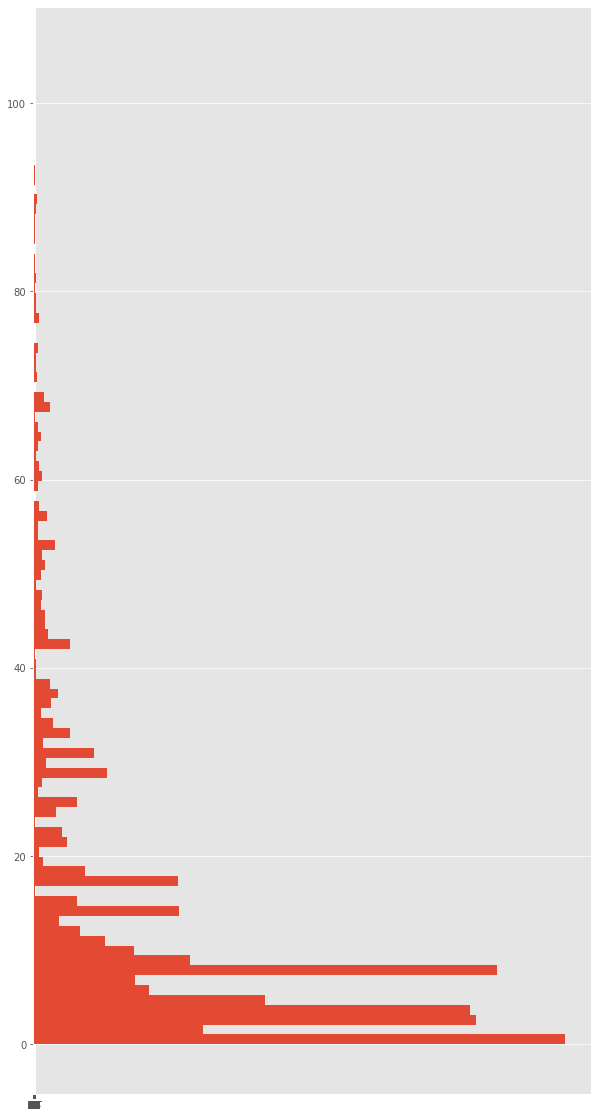

In [47]:
x = note_cpt_icd.loc[:,'CPT_CD'].astype(str).str.slice(start=-2)
fig = plt.figure(figsize=(10, 20))
plt.hist(x.values,bins=100,orientation='horizontal')
plt.show

In [37]:
x = note_cpt_icd.loc[:,'CPT_CD'].astype(str).str.slice(start=-2)
x

0         02
1         03
2         23
3         33
4         32
          ..
234492    47
234493    95
234494    20
234495    30
234496    40
Name: CPT_CD, Length: 234497, dtype: object

In [ ]:
note = nltk.Text(note_cpt_icd.loc[:,'TEXT'][0])
note

In [ ]:
import string
note = note_cpt_icd.loc[:,'TEXT'][0].lower().split()
note = nltk.Text(note)
print(nltk.FreqDist(note))

In [ ]:
note_cpt_icd['NLTK_TEXT'] = nltk.Text(note_cpt_icd['TEXT'])

In [ ]:
def content_fraction(text):
    stopwords = nltk.corpus.stopwords.words('english')
    content = [w for w in text if w.lower() not in stopwords]
    return len(content) / len(text)

for i,t in enumerate(note_cpt_icd['NLTK_TEXT']):
    print(i+1,content_fraction(t))

In [ ]:
note_cpt_icd.head()

In [ ]:
import string
first_text = texts[0].lower().split()
first_text.concordance('patient')

# Tokenize Data

In [ ]:
# Import Packages -----

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data -----

X_train, X_test, y_train, y_test = train_test_split(note_cpt['TEXT'], note_cpt['CPT_CD'], test_size = .33, random_state = 42)

# Tokenize the data -----

# Import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = .7)

# Transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test)

# print(tfidf_vectorizer.get_feature_names()[:10])

# Run Naive Bayes

In [ ]:
# Use Naive Bayes model -----

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb_classifier = MultinomialNB()

# Fit and check accuracy
nb_classifier.fit(tfidf_train, y_train.astype(str))
pred = nb_classifier.predict(tfidf_test)

In [ ]:
# metrics.accuracy_score(y_test.astype(str), pred)

"""
V1 NLP Model Accuracy: 0.117
Wow, I've got a long way to go to improve accuracy
"""

# Confusion matrix 
# confusion_mtrx = metrics.confusion_matrix(y_test.astype(str), pred) # 1380, 1380

In [ ]:
# NLP V2

"""
Here are the changes I am making to improve the score:
* I will be using the max_df arg of the TfidfVectorizer function

"""

In [ ]:
X_train

# Explore the training data